In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import utils.lib_utils
from data import data_utils
from data import orchids52_dataset
from nets import utils
from nets import mobilenet_v2 as mobilenet
from nets import mobilenet_v2_140_orchids52 as mobilenet_140_orchids52

In [2]:
dataset_type = 'orchids52_v1_tf'
model_name = 'mobilenet_v2_140'
batch_size = 16
learning_rate = 0.001
optimizer = 'rmsprop'
exp_decay = False
train_step = 1
num_classes = 52
training = True

In [3]:
workspace_path = os.environ["WORKSPACE"] if "WORKSPACE" in os.environ else "/Volumes/Data/tmp"
data_path = os.environ["DATA_DIR"] if "DATA_DIR" in os.environ else "/Users/watcharinsarachai/Documents/_datasets/"
data_dir = os.path.join(data_path, "orchids52_data")
checkpoint_dir = os.path.join(workspace_path, "orchids-models", "orchids2019", model_name)

In [4]:
load_dataset = data_utils.dataset_mapping[dataset_type]
create_model = utils.nets_mapping[model_name]

In [5]:
if not tf.io.gfile.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [6]:
train_ds = load_dataset(split="train", batch_size=batch_size, root_path=data_dir)
test_ds = load_dataset(split="test", batch_size=batch_size, root_path=data_dir)

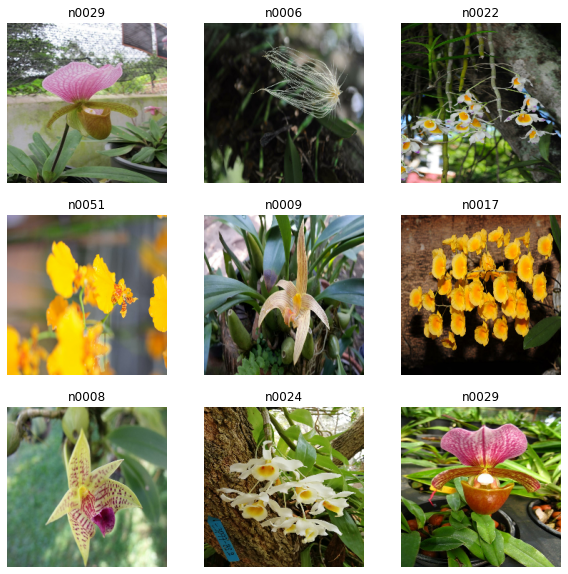

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        label = tf.argmax(labels[i], axis=0)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.classes[label][0])
        plt.axis("off")

In [8]:
training_step = utils.TRAIN_TEMPLATE.format(step=train_step)
learning_rate = lib_utils.config_learning_rate(learning_rate=learning_rate, exp_decay=exp_decay, training_step=training_step)
optimizer = lib_utils.config_optimizer(optimizer, learning_rate=learning_rate, training_step=training_step)
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
learning_rate

0.001

In [9]:
model = create_model(
            num_classes=orchids52_dataset.NUM_OF_CLASSES,
            optimizer=optimizer,
            loss_fn=loss_fn,
            training=training,
            batch_size=batch_size,
            step=training_step,
        )

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
preprocess_layer (Preprocess (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_01_1.40_224 (Fun (None, 7, 7, 1792)        4363712   
_________________________________________________________________
prediction_layer (Prediction (None, 52)                93236     
Total params: 4,456,948
Trainable params: 4,409,012
Non-trainable params: 47,936
_________________________________________________________________


In [11]:
train_model = lib_utils.TrainClassifier(model=model, batch_size=batch_size)

In [12]:
#preprocess_layer = mobilenet_140.PreprocessLayer()
#rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)
#inputs = tf.keras.Input(shape=mobilenet.IMG_SHAPE_224)
#prediction_layer = mobilenet_140.PredictionLayer(num_classes=num_classes, shape=[1, 7, 7], activation="softmax")

In [13]:
#processed_inputs = preprocess_layer(inputs, training=training)
#rescale_inputs = rescale(processed_inputs)
#mobilenet_logits = base_model(rescale_inputs, training=training)
#outputs = prediction_layer(mobilenet_logits, training=training)

In [14]:
#_model = tf.keras.Model(inputs, processed_inputs)
#for images, labels in train_ds.take(1):
#    plt.figure(figsize=(10, 10))
#    first_image = images[0]
#    for i in range(9):
#        ax = plt.subplot(3, 3, i + 1)
#        augmented_image = _model(tf.expand_dims(first_image, 0))
#        plt.imshow(augmented_image.numpy().astype("uint8")[0])
#        plt.axis('off')

In [15]:
#model = tf.keras.Model(inputs, outputs)
#model.summary()

In [21]:
loss0, accuracy0 = model.evaluate(test_ds)

24/24 [==============================] - 25s 648ms/step - loss: 3.9947 - accuracy: 0.0163


In [22]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 3.99
initial accuracy: 0.01


In [ ]:
history = model.fit(train_ds, epochs=100)

Epoch 1/100
     27/Unknown - 12s 354ms/step - loss: 3.8997 - accuracy: 0.1493

In [ ]:
loss0, accuracy0 = model.evaluate(test_ds)

In [ ]:
model.save(checkpoint_dir)

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,4.0])
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()